# Kaggle Human Protein Atlas - Single Cell Classification Challenge

- https://www.kaggle.com/c/hpa-single-cell-image-classification
- https://github.com/bioimage-io/use-cases/tree/main/case3-devtools

# 1. Setup

### 1a. Load BioImage Models

- https://doi.org/10.5281/zenodo.6200999
- https://doi.org/10.5281/zenodo.6200635

In [ ]:
import bioimageio.core

bioimageio.core.export_resource_package("10.5281/zenodo.6200999", output_path="model-nuc.zip")
nuc_model = bioimageio.core.load_resource_description("model-nuc.zip")

bioimageio.core.export_resource_package("10.5281/zenodo.6200635", output_path="model-cell.zip")
cell_model = bioimageio.core.load_resource_description("model-cell.zip")

### 1b. Create Prediction Pipelines

In [ ]:
from bioimageio.core.prediction import predict_with_padding

from xarray import DataArray
from skimage.measure import label
from skimage.segmentation import watershed

pp_nucleus = bioimageio.core.create_prediction_pipeline(bioimageio_model=nuc_model)
pp_cell = bioimageio.core.create_prediction_pipeline(bioimageio_model=cell_model)

### 1c. Prepare Image Dataset

In [ ]:
# red microtubule, blue nuclei, green protein, yellow endoplasmic reticulum
channels = ["red", "blue", "green"]
scale_factor = 0.25

In [ ]:
hpa_cyto = "921_B9_1_"
hpa_endo = "1876_A7_32_"
hpa_mito = "946_E10_1_"
hpa_nucl = "962_F1_1_"

In [ ]:
image_paths = dict()
for hpa in [hpa_cyto, hpa_endo, hpa_mito, hpa_nucl]:
    filepaths = []
    for channel in channels:
        filepaths.append("images/" + hpa + channel + ".png")
    image_paths[hpa] = filepaths

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

from skimage.transform import rescale

In [ ]:
def load_image(image_paths, channels, scale_factor):
    image = []
    for chan in channels:
        path = [imp for imp in image_paths if chan in imp]
        path = path[0]
        im = imageio.imread(path)
        im = rescale(im, scale_factor)
        image.append(im[None])
    image = np.concatenate(image, axis=0)
    return image

# 2. Analysis

### 2a. Select Dataset

In [71]:
hpa = hpa_nucl

### 2b. Load Images

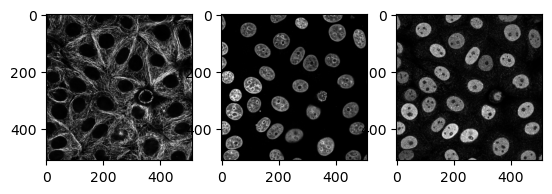

In [72]:
image = load_image(image_paths[hpa], channels, scale_factor)

fig, axes = plt.subplots(1,len(channels))
for i in range(len(channels)):
    axes[i].imshow(image[i,:,:], cmap='gray')

### 2c.Identify Nuclei

In [73]:
axes = cell_model.inputs[0].axes
input_nucleus = DataArray(
    np.concatenate([image[1:2], image[1:2], image[1:2]], axis=0)[None],
    dims=axes
)
padding = {"x": 32, "y": 32}
nuclei_pred = predict_with_padding(pp_nucleus, input_nucleus, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


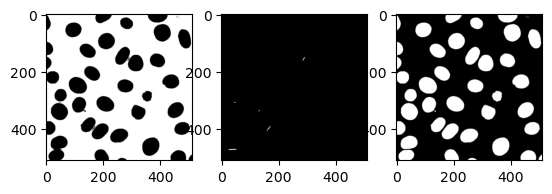

In [74]:
fig, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(nuclei_pred[i,:,:], cmap='gray')

In [75]:
fg = nuclei_pred[-1]
nuclei = label(fg > 0.5)
ids, sizes = np.unique(nuclei, return_counts=True)

In [76]:
filter_ids = ids[sizes < 250]
nuclei[np.isin(nuclei, filter_ids)] = 0

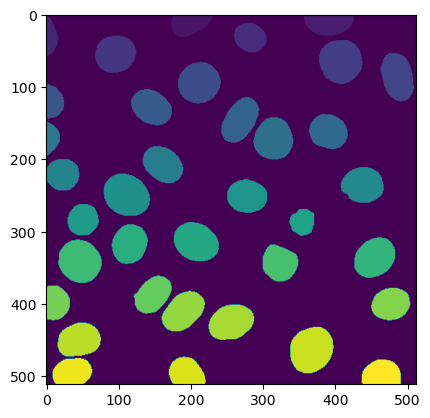

In [77]:
plt.subplots()
plt.imshow(nuclei)

### 2d. Identify Cells

In [78]:
axes = cell_model.inputs[0].axes
input_cells = DataArray(image[None], dims=axes)
cell_pred = predict_with_padding(pp_cell, input_cells, padding=padding)[0].values[0]

code/__torch__/torch/nn/functional.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


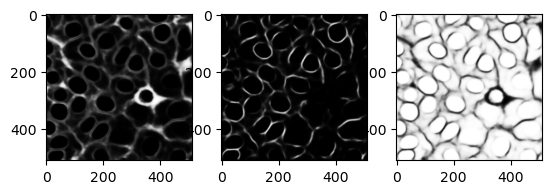

In [79]:
fix, axes = plt.subplots(1,3)
for i in range(3):
    axes[i].imshow(cell_pred[i], cmap='gray')

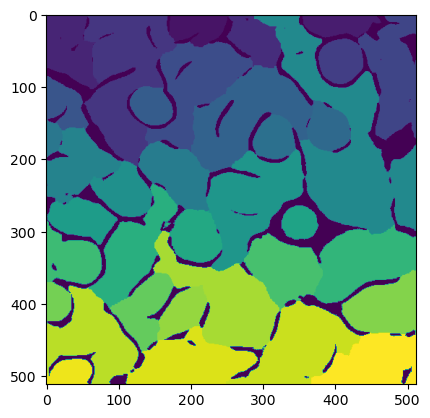

In [80]:
fg, bd = cell_pred[2], cell_pred[1]
cell_seg = watershed(bd, markers=nuclei, mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

In [81]:
ids, sizes = np.unique(cell_seg, return_counts=True)

In [82]:
sizes

array([27269,  2846,  2724,  5341,  3694, 15393,  3051,  8741, 10135,
        2798,  2461, 12706,  3082,  2781,   871,  5929,  6160, 24570,
        4116, 12238,  3899,  1876,  4105,  8281,  9793,  4449,  6958,
        4771,  1603,  6366,  3188, 12028,  9272, 10779,  8684,  1846,
        7340])

# 3. Exercises

- Explain the parameters provided to watershed().  What happens when you remove mask?  What happens when you remove markers?


bd = image, our image.

markers=nuclei, here markers argument is a specific number of labels within the image that nuclei is passing. Nuclei resulted from a binary mask a few cells back that identified potential locations of our nuclei. Removing markers argument resorts it to none, which identifies markers based on the local minima of the image followed by measuring connectiveness of points along the image array to identify nuclei. 

mask=fg > 0.5, here the mask argument is taking in a boolean mask of fg where only values of 0.5 or greater will be passed. mask in watershed() will only point to True values, so for fg it will only be true where values are greater than 0.5.  If we don't pass mask, watershed will be applied to the whole image instead of just at specific locations outlined by the boolean mask, resulting in lower quality analysis. 
- Compare how well segmentation works for cyto, endo, mito, and nucl.  What types of samples work well?  Not as well?

### Remove Markers
- boundaries get a bit distorted and it appears to be less accurate. 

### Remove Mask
- Edges are removed, relies on the color boundaries 


###
2b. Compare how well segmentation works for cyto, endo, mito, and nucl. What types of samples work well? Not as well?
- Cyto, it works okay. there are broken boundaries though. 
- Endo, this one seems to work relatively well in sections with high fluorescence but not in areas of low. This does make sense as edges aren't able to be classified as much. 
- Mito, this one worked very well.  most likely in part do the very clear cell boundaries(unlike cyto/endo). 
- Nucl, this one was okay. I would suspect as there is so much going on and no clear fluorescent boundaries that it was difficult. 


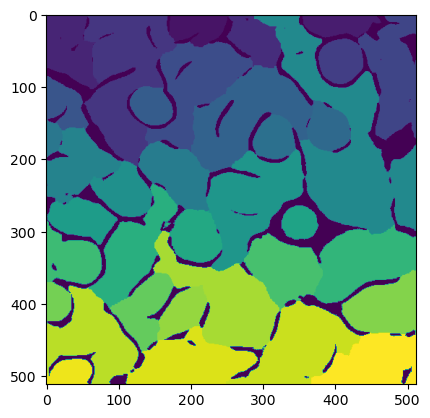

In [83]:
cell_seg = watershed(bd,markers=nuclei,mask=fg > 0.5)

plt.subplots()
plt.imshow(cell_seg)

In [84]:
hpa = hpa_cyto